In [1]:
!pip install timm==0.6.5
!pip install fastai==2.7.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.8/512.8 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.6/213.6 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: fastcore
    Found existing installation: fastcore 1.5.6
    Uninstalling fastcore-1.5.6:
      Successfully uninstalled fastcore-1.5.6
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.7
    Uninstalling fastai-2.7.7:
      Successfully uninstalled fastai-2.7.7


In [2]:
import timm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from scipy.stats import gmean
import gc

In [3]:
from fastai.vision.all import *
set_seed(2022)

In [4]:
# Paths
data_dir = '../input/microsoft-rice-disease-classification-challenge'

tr_df = pd.read_csv(f'{data_dir}/Train.csv')
te_df = pd.read_csv(f'{data_dir}/Test.csv')
subs = pd.read_csv(f'{data_dir}/SampleSubmission.csv')


(500, 400)


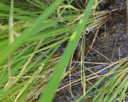

In [5]:
# Get images paths
img_path = '../input/microsoft-rice-disease-classification-challenge/Images'
files = get_image_files(img_path)

# Show on image
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)


In [6]:
tr_rgb = tr_df[~tr_df.Image_id.str.contains('_rgn')].reset_index(drop=True) # Just the RGB images
tr_rgb[:3]

,Image_id,Label
0,id_004wknd7qd.jpg,blast
1,id_005sitfgr2.jpg,brown
2,id_00stp9t6m6.jpg,blast


In [7]:
from sklearn.model_selection import StratifiedKFold

In [8]:
def train(train_ds, test_ds, backbone, item, batch, epochs):
    dls = ImageDataLoaders.from_df(train_ds, fn_col='Image_id', label_col='Label', seed= 2022, bs=16, valid_col="is_valid",
                                   folder=img_path, item_tfms=item, batch_tfms = batch)
    
    learn = vision_learner(dls, backbone, metrics=error_rate, opt_func=RAdam).to_fp16()

    callbacks = [SaveModelCallback(),
                 ReduceLROnPlateau(monitor='valid_loss', patience=3),
                ]
    
    learn.fine_tune(epochs, 0.01, cbs= callbacks)
    
    valid = learn.dls.valid
    val_preds, targets = learn.tta(dl=valid, n=8)
    
    te_preds, _ = learn.tta(dl=dls.test_dl(test_ds), n=8)
    
    logloss = log_loss(targets, val_preds) 
    
    return logloss, te_preds.numpy(), val_preds.numpy(), learn

In [9]:
set_seed(2022,True)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2022)

te_dataset = te_df[~te_df.Image_id.str.contains('_rgn')] # Just the RGB images

train_preds = np.zeros((tr_rgb.shape[0],3)) 

preds = []
scores = []
i=0
for idx , (tr , val) in enumerate(skf.split(tr_rgb, tr_rgb['Label'])):
    print(f'########### Fold {i+1} / {skf.n_splits} ')
    tr_rgb['is_valid'] = False
    tr_rgb.at[val, 'is_valid'] = True

    score, te_preds, val_preds, learn = train(tr_rgb, te_dataset,'swinv2_large_window12_192_22k', item=Resize(400),
                                              batch=aug_transforms(size=192, min_scale=0.75), epochs=20)
    

    print(f'log loss: {score}')
    train_preds[val] = val_preds
    preds.append(te_preds)
    scores.append(score)
    
    labels = learn.dls.vocab
    del score, te_preds, val_preds, learn ; gc.collect()
    torch.cuda.empty_cache()
  
    i+=1
    
print(f'mean logloss: {np.mean(scores)}')

########### Fold 1 / 10 


/opt/conda/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v2.0.0/swinv2_large_patch4_window12_192_22k.pth" to /root/.cache/torch/hub/checkpoints/swinv2_large_patch4_window12_192_22k.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.923235,0.548215,0.164794,01:23


Better model found at epoch 0 with valid_loss value: 0.5482147932052612.


epoch,train_loss,valid_loss,error_rate,time
0,0.491774,0.357873,0.104869,01:47
1,0.400734,0.402144,0.097378,01:46
2,0.372089,0.289115,0.082397,01:46
3,0.355105,0.464401,0.116105,01:47
4,0.362958,0.190932,0.056180,01:46
5,0.328851,0.282549,0.074906,01:47
6,0.334166,0.229363,0.067416,01:47
7,0.269940,0.336596,0.097378,01:46
8,0.207265,0.183288,0.048689,01:47
9,0.196580,0.432139,0.093633,01:47


Better model found at epoch 0 with valid_loss value: 0.3578733503818512.
Better model found at epoch 2 with valid_loss value: 0.289114773273468.
Better model found at epoch 4 with valid_loss value: 0.19093208014965057.
Epoch 7: reducing lr to 0.000475404487872845
Better model found at epoch 8 with valid_loss value: 0.18328766524791718.
Epoch 11: reducing lr to 0.0003059967460289783
Better model found at epoch 12 with valid_loss value: 0.15505951642990112.
Epoch 15: reducing lr to 9.442420459722942e-05
Epoch 18: reducing lr to 6.35644621047116e-06


log loss: 0.13479938086881826
########### Fold 2 / 10 


epoch,train_loss,valid_loss,error_rate,time
0,0.914748,0.444538,0.149813,01:19


Better model found at epoch 0 with valid_loss value: 0.4445377588272095.


epoch,train_loss,valid_loss,error_rate,time
0,0.613523,0.263064,0.104869,01:46
1,0.451181,0.332006,0.108614,01:47
2,0.393762,0.773931,0.205993,01:46
3,0.421107,0.339078,0.116105,01:46
4,0.371275,0.355698,0.093633,01:47
5,0.360558,0.191384,0.063670,01:47
6,0.310533,0.214403,0.052434,01:47
7,0.269399,0.143602,0.044944,01:47
8,0.190972,0.273467,0.101124,01:47
9,0.162740,0.151395,0.052434,01:47


Better model found at epoch 0 with valid_loss value: 0.26306411623954773.
Epoch 3: reducing lr to 0.000399394781950452
Better model found at epoch 5 with valid_loss value: 0.19138354063034058.
Better model found at epoch 7 with valid_loss value: 0.14360201358795166.
Better model found at epoch 10 with valid_loss value: 0.12744140625.
Better model found at epoch 12 with valid_loss value: 0.061970122158527374.
Epoch 15: reducing lr to 9.442420459722942e-05
Epoch 18: reducing lr to 6.35644621047116e-06


log loss: 0.046545480048695714
########### Fold 3 / 10 


epoch,train_loss,valid_loss,error_rate,time
0,0.940118,0.466314,0.191011,01:18


Better model found at epoch 0 with valid_loss value: 0.4663141965866089.


epoch,train_loss,valid_loss,error_rate,time
0,0.461226,0.237798,0.078652,01:47
1,0.443742,0.267828,0.112360,01:47
2,0.371516,0.431106,0.179775,01:47
3,0.451184,0.291000,0.119850,01:47
4,0.376230,0.465951,0.176030,01:47
5,0.330897,0.672093,0.149813,01:47
6,0.330295,0.436548,0.164794,01:47
7,0.262285,0.174222,0.056180,01:47
8,0.197813,0.152683,0.044944,01:47
9,0.115800,0.127319,0.041199,01:47


Better model found at epoch 0 with valid_loss value: 0.23779839277267456.
Epoch 3: reducing lr to 0.000399394781950452
Epoch 6: reducing lr to 0.0004938149954129391
Better model found at epoch 7 with valid_loss value: 0.17422173917293549.
Better model found at epoch 8 with valid_loss value: 0.15268343687057495.
Better model found at epoch 9 with valid_loss value: 0.1273193061351776.
Better model found at epoch 10 with valid_loss value: 0.10706733167171478.
Better model found at epoch 13 with valid_loss value: 0.0782943144440651.
Better model found at epoch 14 with valid_loss value: 0.06473910063505173.
Epoch 17: reducing lr to 2.4925051969879737e-05


log loss: 0.04227915313865783
########### Fold 4 / 10 


epoch,train_loss,valid_loss,error_rate,time
0,0.963990,0.869841,0.250936,01:19


Better model found at epoch 0 with valid_loss value: 0.8698405623435974.


epoch,train_loss,valid_loss,error_rate,time
0,0.464593,0.317465,0.093633,01:46
1,0.457450,0.261389,0.093633,01:47
2,0.416252,0.234589,0.067416,01:47
3,0.376597,0.279382,0.089888,01:47
4,0.383087,0.337603,0.142322,01:47
5,0.335156,0.372243,0.101124,01:47
6,0.318027,0.261068,0.048689,01:47
7,0.252252,0.209801,0.074906,01:47
8,0.226179,0.224333,0.082397,01:47
9,0.162706,0.177333,0.056180,01:47


Better model found at epoch 0 with valid_loss value: 0.31746527552604675.
Better model found at epoch 1 with valid_loss value: 0.2613888680934906.
Better model found at epoch 2 with valid_loss value: 0.23458854854106903.
Epoch 5: reducing lr to 0.0004999987814467291
Better model found at epoch 7 with valid_loss value: 0.20980124175548553.
Better model found at epoch 9 with valid_loss value: 0.17733262479305267.
Better model found at epoch 10 with valid_loss value: 0.15388090908527374.
Better model found at epoch 11 with valid_loss value: 0.09400197863578796.
Better model found at epoch 13 with valid_loss value: 0.08408629149198532.
Better model found at epoch 14 with valid_loss value: 0.06788913905620575.
Epoch 17: reducing lr to 2.4925051969879737e-05


log loss: 0.06466348932369462
########### Fold 5 / 10 


epoch,train_loss,valid_loss,error_rate,time
0,0.921135,0.442545,0.138577,01:19


Better model found at epoch 0 with valid_loss value: 0.4425445795059204.


epoch,train_loss,valid_loss,error_rate,time
0,0.499376,0.389587,0.138577,01:47
1,0.438631,0.254403,0.082397,01:47
2,0.343650,0.347607,0.097378,01:47
3,0.417184,0.241803,0.082397,01:47
4,0.338130,0.625400,0.142322,01:47
5,0.317485,0.259630,0.044944,01:47
6,0.320364,0.150786,0.063670,01:47
7,0.239286,0.254773,0.078652,01:47
8,0.216072,0.163275,0.048689,01:47
9,0.124377,0.304697,0.089888,01:47


Better model found at epoch 0 with valid_loss value: 0.38958656787872314.
Better model found at epoch 1 with valid_loss value: 0.25440314412117004.
Better model found at epoch 3 with valid_loss value: 0.24180328845977783.
Better model found at epoch 6 with valid_loss value: 0.15078574419021606.
Epoch 9: reducing lr to 0.0004061656235215956
Epoch 12: reducing lr to 0.0002503765116081439
Better model found at epoch 14 with valid_loss value: 0.14471791684627533.
Epoch 17: reducing lr to 2.4925051969879737e-05


log loss: 0.11206049409272631
########### Fold 6 / 10 


epoch,train_loss,valid_loss,error_rate,time
0,0.909951,0.574964,0.217228,01:19


Better model found at epoch 0 with valid_loss value: 0.5749637484550476.


epoch,train_loss,valid_loss,error_rate,time
0,0.526144,0.277317,0.082397,01:46
1,0.432216,0.338755,0.097378,01:47
2,0.384878,0.334249,0.112360,01:47
3,0.356111,0.574949,0.153558,01:47
4,0.391723,0.420175,0.142322,01:47
5,0.313157,0.311964,0.104869,01:47
6,0.295988,0.244596,0.089888,01:47
7,0.285041,0.531346,0.157303,01:47
8,0.221174,0.263588,0.071161,01:48
9,0.183083,0.345955,0.086142,01:47


Better model found at epoch 0 with valid_loss value: 0.27731746435165405.
Epoch 3: reducing lr to 0.000399394781950452
Better model found at epoch 6 with valid_loss value: 0.24459587037563324.
Epoch 9: reducing lr to 0.0004061656235215956
Better model found at epoch 10 with valid_loss value: 0.15267372131347656.
Better model found at epoch 12 with valid_loss value: 0.14459967613220215.
Epoch 15: reducing lr to 9.442420459722942e-05
Better model found at epoch 16 with valid_loss value: 0.12857367098331451.
Better model found at epoch 17 with valid_loss value: 0.1190781369805336.


log loss: 0.07802967832089211
########### Fold 7 / 10 


epoch,train_loss,valid_loss,error_rate,time
0,1.001177,0.671073,0.243446,01:19


Better model found at epoch 0 with valid_loss value: 0.6710732579231262.


epoch,train_loss,valid_loss,error_rate,time
0,0.512669,0.250546,0.093633,01:46
1,0.454516,0.316335,0.101124,01:47
2,0.394731,0.219373,0.074906,01:47
3,0.358781,0.647694,0.194757,01:47
4,0.328997,0.286383,0.089888,01:47
5,0.297759,0.555889,0.157303,01:48
6,0.304362,0.303292,0.104869,01:47
7,0.283415,0.161325,0.044944,01:47
8,0.158019,0.290836,0.093633,01:47
9,0.187963,0.167706,0.052434,01:47


Better model found at epoch 0 with valid_loss value: 0.250545859336853.
Better model found at epoch 2 with valid_loss value: 0.2193729430437088.
Epoch 5: reducing lr to 0.0004999987814467291
Better model found at epoch 7 with valid_loss value: 0.16132529079914093.
Epoch 10: reducing lr to 0.00035880921654888877
Better model found at epoch 13 with valid_loss value: 0.10644251853227615.
Better model found at epoch 15 with valid_loss value: 0.10628895461559296.
Epoch 18: reducing lr to 6.35644621047116e-06


log loss: 0.1035286510856507
########### Fold 8 / 10 


epoch,train_loss,valid_loss,error_rate,time
0,0.930614,0.677985,0.220974,01:19


Better model found at epoch 0 with valid_loss value: 0.677984893321991.


epoch,train_loss,valid_loss,error_rate,time
0,0.492570,0.349504,0.112360,01:47
1,0.384104,0.358890,0.093633,01:47
2,0.380173,0.271195,0.097378,01:47
3,0.304156,0.474948,0.183521,01:47
4,0.346121,0.541796,0.142322,01:47
5,0.356360,0.512007,0.146067,01:47
6,0.291906,0.173938,0.059925,01:47
7,0.213190,0.274203,0.093633,01:47
8,0.250022,0.411647,0.086142,01:47
9,0.187090,0.192998,0.056180,01:47


Better model found at epoch 0 with valid_loss value: 0.34950387477874756.
Better model found at epoch 2 with valid_loss value: 0.2711953818798065.
Epoch 5: reducing lr to 0.0004999987814467291
Better model found at epoch 6 with valid_loss value: 0.1739378571510315.
Epoch 9: reducing lr to 0.0004061656235215956
Epoch 12: reducing lr to 0.0002503765116081439
Better model found at epoch 14 with valid_loss value: 0.14370577037334442.
Epoch 17: reducing lr to 2.4925051969879737e-05


log loss: 0.11540305819644285
########### Fold 9 / 10 


epoch,train_loss,valid_loss,error_rate,time
0,0.963095,0.742289,0.228464,01:19


Better model found at epoch 0 with valid_loss value: 0.7422893643379211.


epoch,train_loss,valid_loss,error_rate,time
0,0.509680,0.228683,0.074906,01:46
1,0.443669,0.237736,0.086142,01:47
2,0.398324,0.421565,0.138577,01:47
3,0.427831,0.287280,0.093633,01:47
4,0.372990,0.143812,0.041199,01:47
5,0.329937,0.182401,0.052434,01:47
6,0.300654,0.510724,0.134831,01:46
7,0.275488,0.264360,0.089888,01:46
8,0.234866,0.250453,0.078652,01:47
9,0.173894,0.227469,0.067416,01:47


Better model found at epoch 0 with valid_loss value: 0.228682741522789.
Epoch 3: reducing lr to 0.000399394781950452
Better model found at epoch 4 with valid_loss value: 0.14381162822246552.
Epoch 7: reducing lr to 0.000475404487872845
Better model found at epoch 10 with valid_loss value: 0.09190020710229874.
Epoch 13: reducing lr to 0.00019473747703102178
Epoch 16: reducing lr to 5.477998885379809e-05
Better model found at epoch 17 with valid_loss value: 0.07028496265411377.


log loss: 0.05593174515303283
########### Fold 10 / 10 


epoch,train_loss,valid_loss,error_rate,time
0,0.959281,0.554283,0.179775,01:19


Better model found at epoch 0 with valid_loss value: 0.5542833209037781.


epoch,train_loss,valid_loss,error_rate,time
0,0.535405,0.283095,0.082397,01:46
1,0.388850,0.298908,0.097378,01:46
2,0.456478,0.466860,0.116105,01:47
3,0.410443,0.614358,0.179775,01:47
4,0.355721,0.553318,0.116105,01:47
5,0.340876,0.234889,0.059925,01:47
6,0.219634,0.492718,0.101124,01:47
7,0.285790,0.314098,0.086142,01:47
8,0.263010,0.229606,0.063670,01:47
9,0.134414,0.236054,0.067416,01:47


Better model found at epoch 0 with valid_loss value: 0.2830953299999237.
Epoch 3: reducing lr to 0.000399394781950452
Better model found at epoch 5 with valid_loss value: 0.2348887026309967.
Better model found at epoch 8 with valid_loss value: 0.22960585355758667.
Better model found at epoch 10 with valid_loss value: 0.20237527787685394.
Epoch 13: reducing lr to 0.00019473747703102178
Epoch 16: reducing lr to 5.477998885379809e-05
Epoch 19: reducing lr to 5.2797373038641905e-09


log loss: 0.16927604415003933
mean logloss: 0.09225171743786505


In [10]:
final_test_predictions = gmean(preds, axis=0)
submission = pd.DataFrame({'Image_id': te_dataset['Image_id']})

for i, label in enumerate(labels):
    submission[label] = final_test_predictions[:,i] 
    
submission.to_csv('./subs.csv', index=False)